<a href="https://colab.research.google.com/github/DemarchiWorking/AXIOS-API-VUE/blob/master/model_lifeCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dimensoes do dataset dps preprocessamento: (495, 31)


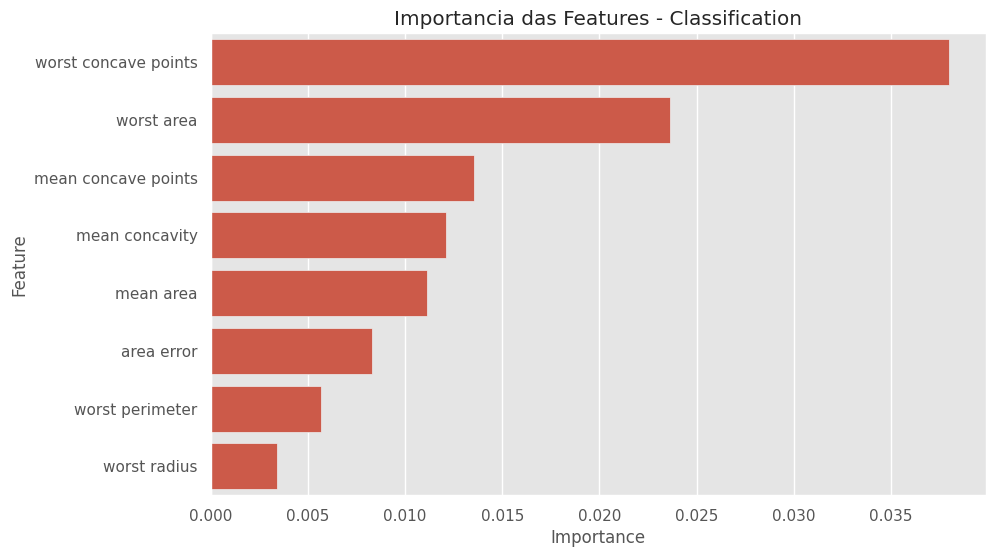


Melhores features para classification:
Top 10 Mutual Info: ['worst perimeter', 'worst area', 'worst radius', 'mean concave points', 'worst concave points', 'mean perimeter', 'mean concavity', 'mean area', 'mean radius', 'area error']
RFE Features: ['mean area', 'mean concavity', 'mean concave points', 'area error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst concavity', 'worst concave points']
Features selecionadas: ['mean concave points', 'worst concave points', 'mean area', 'mean concavity', 'area error', 'worst area', 'worst radius', 'worst perimeter']

Importancia das Features:
                Feature  Importance
1  worst concave points    0.037980
5            worst area    0.023636
0   mean concave points    0.013535
3        mean concavity    0.012121
2             mean area    0.011111
4            area error    0.008283
7       worst perimeter    0.005657
6          worst radius    0.003434


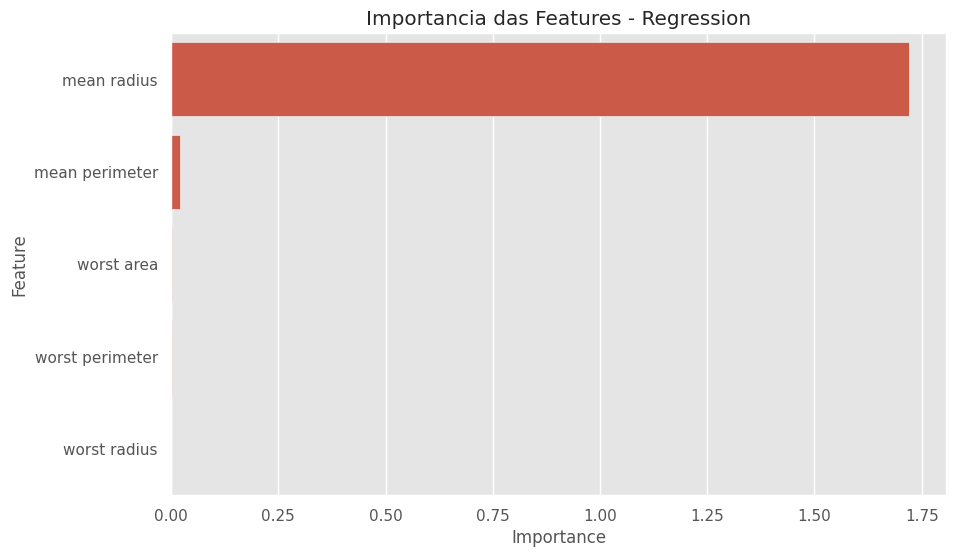


Melhores features para regression:
Top 10 Mutual Info: ['mean radius', 'mean perimeter', 'worst area', 'worst radius', 'worst perimeter', 'area error', 'mean concave points', 'worst concave points', 'mean concavity', 'perimeter error']
RFE Features: ['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean compactness', 'mean fractal dimension', 'fractal dimension error', 'worst radius', 'worst perimeter', 'worst area']
Features selecionadas: ['worst area', 'mean radius', 'worst radius', 'mean perimeter', 'worst perimeter']

Importancia das Features:
           Feature  Importance
1      mean radius    1.720844
3   mean perimeter    0.021133
0       worst area    0.001008
4  worst perimeter    0.000889
2     worst radius    0.000583


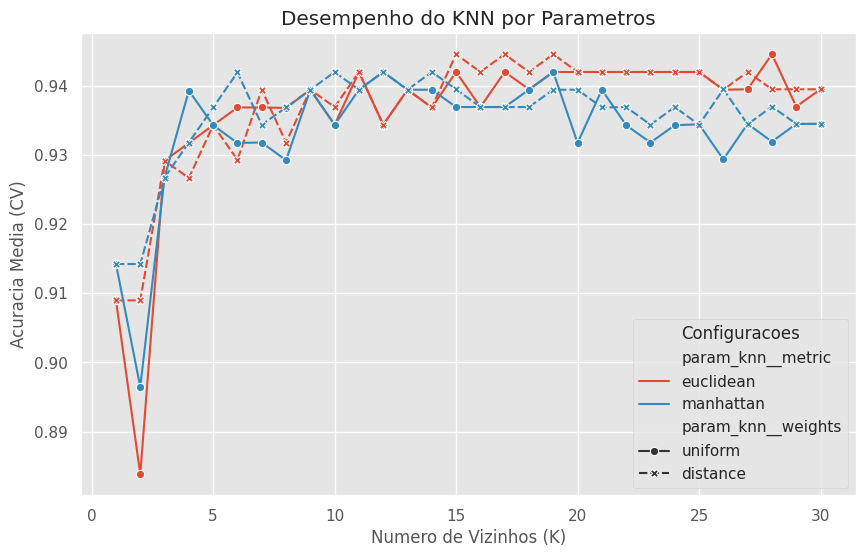

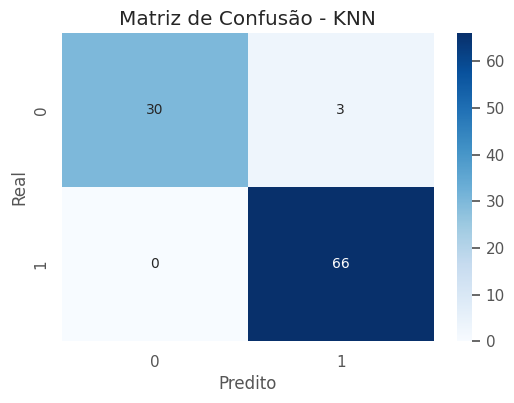

KNN original - acuracia: 0.9697, melhor K: 15
Acuracia CV (dados expandidos): 0.9709 ± 0.0170
modelo final (com dados sinteticos) - acuracia: 0.9899

Linear:
R² (CV): 0.9996
R² (Teste): 0.9998
MSE: 0.0003

Ridge:
R² (CV): 0.9990
R² (Teste): 0.9994
MSE: 0.0007

RandomForest:
R² (CV): 0.9978
R² (Teste): 0.9956
MSE: 0.0057


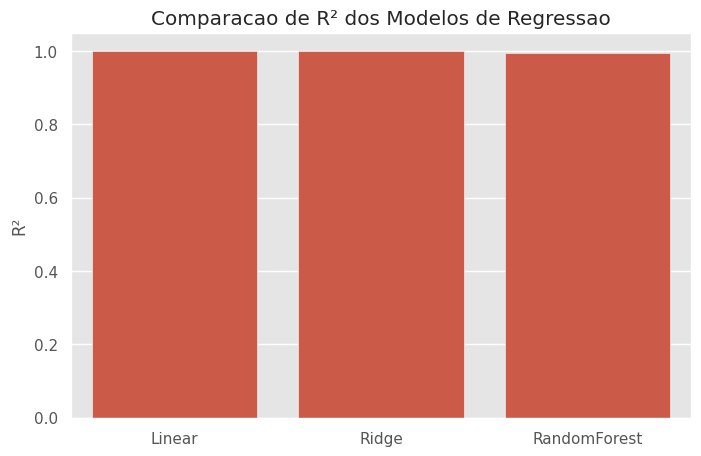

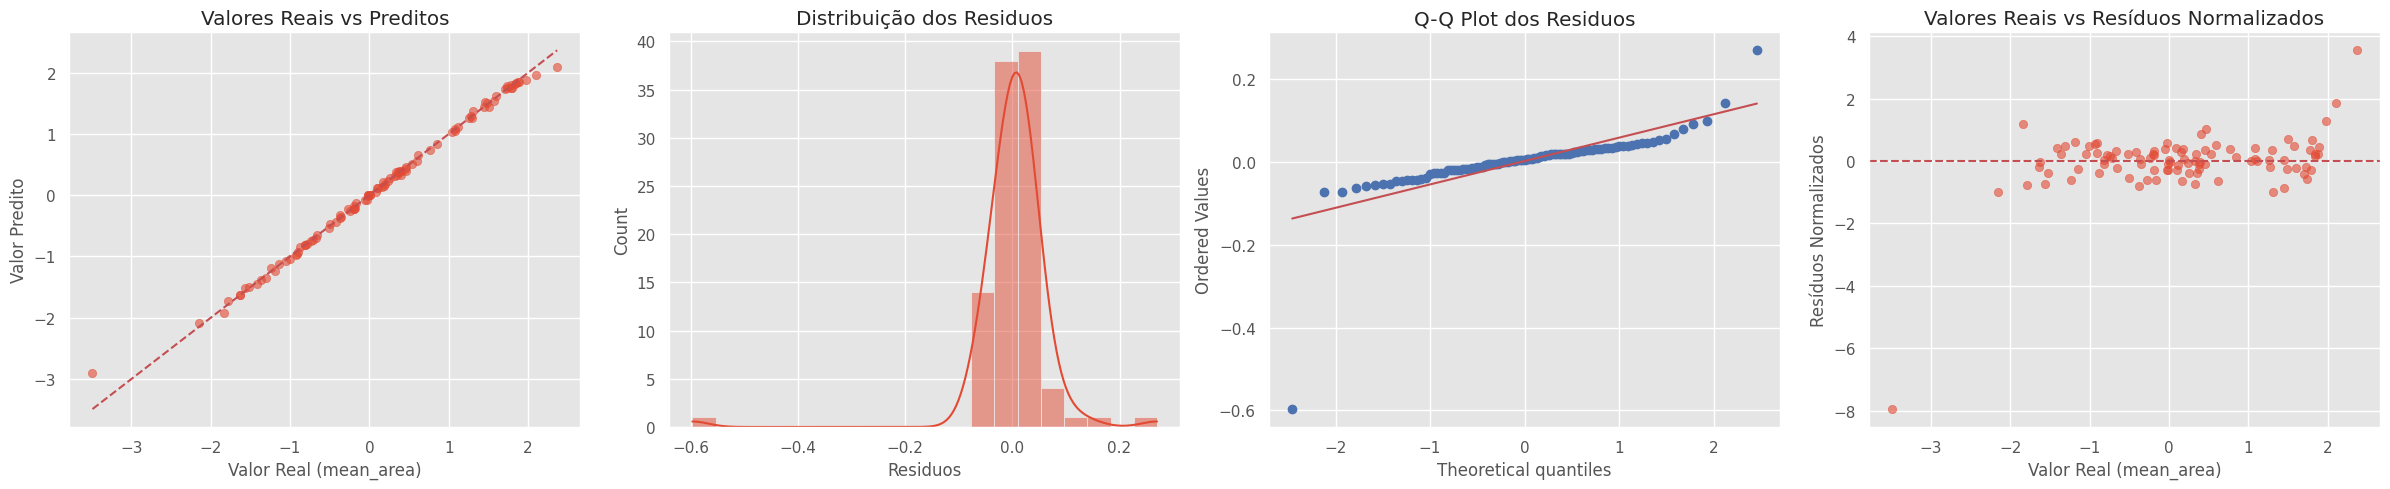


Estatísticas dos Resíduos:
Média: 0.0024
Variância: 0.0057
Assimetria: -4.5283
Curtose: 39.0692
Melhor R²: 0.9956 (RandomForestRegressor)

 RESULTADOS FINAIS 

 CLASSIFICACAO 
melhor modelo: KNN (k=15)
acuracia final: 0.9899
features selecionadas: ['mean concave points', 'worst concave points', 'mean area', 'mean concavity', 'area error', 'worst area', 'worst radius', 'worst perimeter']
REGRESSAO
melhor modelo: RandomForestRegressor
R² final: 0.9956
features selecionadas: ['worst area', 'mean radius', 'worst radius', 'mean perimeter', 'worst perimeter']
nenhum vazamento de dados detectado.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, RFE
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE
from scipy import stats
import pickle
import warnings
import os

# estilizar os gráficos
sns.set_theme(style="whitegrid")
plt.style.use("ggplot")

np.random.seed(42)  #42- define semente

# carregamento e preprocessamento
# verificar qualidade, remover outliers e normalizar as features
def carregar_e_preprocessar_dados(save_preprocessors=True):
    try:
        # carregar o dataset
        dados = load_breast_cancer()
        df = pd.DataFrame(dados.data, columns=dados.feature_names)  # Converte os dados em DataFrame
        df['target'] = dados.target  # adiciona coluna target (0: benigno, 1: maligno)

        # verificar dados faltantes
        if df.isnull().sum().sum() > 0:
            raise ValueError("existe dados faltantes!")

        #remove outliers usando z-scores, n ficar com valores extremos
        z_scores = np.abs(stats.zscore(df.drop(columns=['target'])))  # calcula z-scores para as features
        df = df[(z_scores < 3).all(axis=1)]  # mantem apenas linhas com z-scores maoir q 3

        # aplica normalizacao
        pt = PowerTransformer(method='yeo-johnson')
        num_cols = df.select_dtypes(include=np.number).columns.drop(['target'])
        df[num_cols] = pt.fit_transform(df[num_cols])

        # salva para uso dps
        if save_preprocessors:
            with open('power_transformer.pkl', 'wb') as f:
                pickle.dump(pt, f)

        print(f"dimensoes do dataset dps preprocessamento: {df.shape}")
        return df
    except Exception as e:
        print(f"[Erro] Durante o preprocessamento: {str(e)}")
        return None

# carrega e preprocessa os dados
df = carregar_e_preprocessar_dados()
if df is None:
    raise SystemExit("[Erro] falha no carregamento dos dados.")

# separa os dados para classificacao e regressao (conjuntos de treino e teste)
X_class = df.drop(columns=['target'])                       #features para classificacao
y_class = df['target']                                      # target para classificacao
X_reg = df.drop(columns=['target', 'mean area'])            # features para regressao (remove mean_area)
y_reg = df['mean area']                                     # target para regressão

# divide os dados para classificacao (80/20, c/estratificacao)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class
)

# divide dados p regressao (80/20)
# criar conjuntos de treino e teste para prever mean_area
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


# seleção de Features
# escolher as melhores features usando mutual information e RFE
def selecionar_features(X, y, tarefa='classification', k=10):
    # usar metrica apropriada para classificacao /regressao
    score_func = mutual_info_classif if tarefa == 'classification' else mutual_info_regression
    mi = SelectKBest(score_func=score_func, k='all')  # seleciona todas as features inicialmente
    mi.fit(X, y)  # ajusta o seletor de features
    mi_scores = pd.Series(mi.scores_, index=X.columns).sort_values(ascending=False)  # calcula scores

    # escolher com RFE as k features
    # complementar a selecao com um metodo baseado em modelo
    estimator = RandomForestClassifier(random_state=42) if tarefa == 'classification' else RandomForestRegressor(random_state=42)
    rfe = RFE(estimator, n_features_to_select=k)  # seleciona k features
    rfe.fit(X, y)  # ajusta o RFE

    # usar os resultados de mutual information e RFE para escolher
    top_mi = mi_scores.head(k).index.tolist()  # top k features por Mutual Information
    rfe_features = X.columns[rfe.support_].tolist()  # features selecionadas por RFE
    selected_features = list(set(top_mi).intersection(rfe_features))  # intersecao das features

    # validar a importancia das features escolhidas
    estimator.fit(X[selected_features], y)
    importance = permutation_importance(estimator, X[selected_features], y, n_repeats=10, random_state=42)
    importance_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    # mostra a importancia das features
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Importancia das Features - {tarefa.capitalize()}')
    plt.show()
    plt.close()

    print(f"\nMelhores features para {tarefa}:")
    print(f"Top {k} Mutual Info: {top_mi}")
    print(f"RFE Features: {rfe_features}")
    print(f"Features selecionadas: {selected_features}")
    print(f"\nImportancia das Features:\n{importance_df}")

    return X[selected_features], selected_features

#seleciona features para classificacao, identificando as melhores features para prever o target
X_class_sel, features_class = selecionar_features(X_class, y_class, 'classification')

#seleciona features para regressão, identificar as melhores features para prever mean_area
X_reg_sel, features_reg = selecionar_features(X_reg, y_reg, 'regression')

# dividir os dados escalonados para classificacao, normalizar os dados selecionados para o KNN
X_train_class_sel, X_test_class_sel, y_train_class, y_test_class = train_test_split(
    X_class_sel, y_class, test_size=0.2, random_state=42, stratify=y_class
)
scaler_class = StandardScaler()  # instancia o escalonador
X_train_class_scaled = scaler_class.fit_transform(X_train_class_sel)  # escala os dados de treino
X_test_class_scaled = scaler_class.transform(X_test_class_sel)  # escala os dados de teste
with open('scaler_classification.pkl', 'wb') as f:
    pickle.dump(scaler_class, f)  # salva o escalonador

# divide os dados escalonados para regressao
# normalizar os dados selecionados para a regressao
X_train_reg_sel, X_test_reg_sel, y_train_reg, y_test_reg = train_test_split(
    X_reg_sel, y_reg, test_size=0.2, random_state=42
)
scaler_reg = StandardScaler()                                       # instancia o escalonador
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg_sel)      # escala os dados de treino
X_test_reg_scaled = scaler_reg.transform(X_test_reg_sel)            # escala os dados de teste
with open('scaler_regression.pkl', 'wb') as f:
    pickle.dump(scaler_reg, f)                                      # salva o escalonador


# treinamento e avaliacao do modelo KNN (otimizar o KNN testando diferentes hiperparametros)
def avaliar_knn(X_train, y_train, X_test, y_test):
    # testar diferentes valores de K, pesos e metricas
    param_grid = {
        'knn__n_neighbors': list(range(1, 31)),
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    }

    # cria um pipeline com o KNN
    pipeline = Pipeline([('knn', KNeighborsClassifier())])

    #realiza busca em grade com validacao cruzada, encontrar uma boa combinacao de hiperparametros
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=StratifiedKFold(n_splits=10),
        scoring='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)  # ajusta o modelo

    # analisar o desempenho por hiperparametro
    resultados = pd.DataFrame(grid.cv_results_)
    best_k = grid.best_params_['knn__n_neighbors']  # mlhor valor de K
    model = grid.best_estimator_  #melhor modelo
    y_pred = model.predict(X_test)  # faz previsoes
    acuracia = accuracy_score(y_test, y_pred)  # calcula acuracia

    # Plota o desempenho por K
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=resultados,
        x='param_knn__n_neighbors',
        y='mean_test_score',
        hue='param_knn__metric',
        style='param_knn__weights',
        markers=True
    )
    plt.title('Desempenho do KNN por Parametros')
    plt.xlabel('Numero de Vizinhos (K)')
    plt.ylabel('Acuracia Media (CV)')
    plt.legend(title='Configuracoes')
    plt.grid(True)
    plt.show()
    plt.close()

    # matriz de confusão, c/acertos e erros do modelo
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - KNN')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()
    plt.close()

    return model, acuracia, best_k

# obter o melhor modelo KNN e sua acuracia
knn_model, knn_acc, best_k = avaliar_knn(X_train_class_scaled, y_train_class, X_test_class_scaled, y_test_class)
print(f"KNN original - acuracia: {knn_acc:.4f}, melhor K: {best_k}")


# geracao e uso de dados sinteticos, p aumentar o conjunto de treino com dados artificiais
def expandir_dados_sinteticos(X_train, y_train, noise_level=0.05):
    # aplica smote para balancear classes e gerar amostras sinteticas para a classe minoritaria
    smote = SMOTE(random_state=42, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)

    # adiciona ruido gaussiano
    np.random.seed(42)
    noise = np.random.normal(0, noise_level, X_smote.shape)
    X_synthetic = X_smote + noise

    return X_synthetic, y_smote

#treinar o modelo final com dados expandidos
def treinar_modelo_final(X_train, y_train, X_test, y_test, best_k):
    # gera dados sinteticos
    X_synth, y_synth = expandir_dados_sinteticos(X_train, y_train)
    X_full = np.vstack([X_train, X_synth])  # combina originais e sinteticos
    y_full = np.concatenate([y_train, y_synth])  #combina rotulos

    # cria pipeline com o melhor K
    pipeline = Pipeline([
        ('knn', KNeighborsClassifier(
            n_neighbors=best_k,
            weights='distance',
            metric='manhattan'
        ))
    ])

    # validacao cruzada p avaliar com dados expandidos
    cv_scores = cross_val_score(
        pipeline, X_full, y_full, cv=StratifiedKFold(n_splits=5), scoring='accuracy'
    )

    # treina o modelo final
    pipeline.fit(X_full, y_full)
    y_pred = pipeline.predict(X_test)
    acuracia = accuracy_score(y_test, y_pred)

    #salva o modelo
    with open('knn_final_model.pkl', 'wb') as f:
        pickle.dump(pipeline, f)

    print(f"Acuracia CV (dados expandidos): {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    return pipeline, acuracia

#treina o modelo com dados sinteticos
#comparar a acuracia com e sem dados sinteticos
final_model, final_acc = treinar_modelo_final(X_train_class_scaled, y_train_class, X_test_class_scaled, y_test_class, best_k)
print(f"modelo final (com dados sinteticos) - acuracia: {final_acc:.4f}")

# --------------------------------------
# treinamento e avaliacao da regressao, comparar diferentes modelos e selecionar o melhor
def treinar_regressao(X_train, y_train, X_test, y_test):
    # define pipeline com interacoes de features
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
        ('scaler', StandardScaler()),
        ('model', RandomForestRegressor(random_state=42))
    ])

    # define grade de hiperparametros p otimizar o modelo RandomForest
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, None],
        'model__min_samples_split': [2, 5]
    }

    # realiza busca em grade
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    # pega o melhor modelo
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred)  # calcula R2
    mse = mean_squared_error(y_test, y_pred)  # calcula MSE

    # compara com outros modelos
    modelos = {
        'Linear': Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                           ('scaler', StandardScaler()),
                           ('model', LinearRegression())]),
        'Ridge': Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
                          ('scaler', StandardScaler()),
                          ('model', Ridge(alpha=1.0))]),
        'RandomForest': best_model
    }

    resultados = {}
    for nome, modelo in modelos.items():
        cv_scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')  # validacao cruzada
        modelo.fit(X_train, y_train)
        y_pred_temp = modelo.predict(X_test)
        r2_temp = r2_score(y_test, y_pred_temp)
        mse_temp = mean_squared_error(y_test, y_pred_temp)
        resultados[nome] = {'r2': r2_temp, 'mse': mse_temp, 'r2_cv': np.mean(cv_scores)}

        print(f"\n{nome}:")
        print(f"R² (CV): {np.mean(cv_scores):.4f}")
        print(f"R² (Teste): {r2_temp:.4f}")
        print(f"MSE: {mse_temp:.4f}")

    # mostrar o desempenho relativo dos modelos
    r2_values = [resultados[model]['r2'] for model in resultados]
    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(resultados.keys()), y=r2_values)
    plt.title('Comparacao de R² dos Modelos de Regressao')
    plt.ylabel('R²')
    plt.show()
    plt.close()

    # visualiza residuos, analisar os erros do melhor modelo
    y_pred_melhor = best_model.predict(X_test)
    residuos = y_test - y_pred_melhor
    residuos_normalizados = (residuos - np.mean(residuos)) / np.std(residuos)

    # cria graficos p analise
    fig, ax = plt.subplots(1, 4, figsize=(24, 5))

    # grafico de Y real vs Y estimado, verificar a correlacao entre valores reais e previstos
    ax[0].scatter(y_test, y_pred_melhor, alpha=0.6)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax[0].set_xlabel('Valor Real (mean_area)')
    ax[0].set_ylabel('Valor Predito')
    ax[0].set_title('Valores Reais vs Preditos')

    # histograma dos residuos, p verificar a distribuicao dos erros
    sns.histplot(residuos, kde=True, bins=20, ax=ax[1])
    ax[1].set_xlabel('Residuos')
    ax[1].set_title('Distribuição dos Residuos')

    # Q-Q Plot, avaliar a normalidade dos residuos
    stats.probplot(residuos, plot=ax[2])
    ax[2].set_title('Q-Q Plot dos Residuos')

    # Y real vs residuo normalizado, verificar a relacao entre residuos e valores reais
    ax[3].scatter(y_test, residuos_normalizados, alpha=0.6)
    ax[3].axhline(y=0, color='r', linestyle='--')
    ax[3].set_xlabel('Valor Real (mean_area)')
    ax[3].set_ylabel('Resíduos Normalizados')
    ax[3].set_title('Valores Reais vs Resíduos Normalizados')

    plt.tight_layout()
    plt.show()
    plt.close()

    #calcula estatisticas dos residuos
    res_stats = {
        'Média': np.mean(residuos),
        'Variância': np.var(residuos),
        'Assimetria': stats.skew(residuos),
        'Curtose': stats.kurtosis(residuos)
    }

    print("\nEstatísticas dos Resíduos:")
    for stat, value in res_stats.items():
        print(f"{stat}: {value:.4f}")

    #salva o modelo
    with open('regression_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)

    return best_model, r2, resultados

#treina os modelos de regressao (obter o melhor modelo para prever mean_area)
best_reg, best_r2, resultados_reg = treinar_regressao(X_train_reg_scaled, y_train_reg, X_test_reg_scaled, y_test_reg)
print(f"Melhor R²: {best_r2:.4f} ({type(best_reg.named_steps['model']).__name__})")

# usa randomForest como modelo principal, com comparação a LinearRegression e Ridge.


# funcao para novos dados
# aplicar o mesmo preprocessamento em novos dados
def processar_novos_dados(df_new, preprocessor_path='power_transformer.pkl'):
    try:
        # verifica colunas esperadas
        expected_columns = load_breast_cancer().feature_names
        missing_cols = [col for col in expected_columns if col not in df_new.columns]
        if missing_cols:
            raise ValueError(f"colunas faltantes nos novos dados: {missing_cols}")

        # carrega o powertransformer
        if not os.path.exists(preprocessor_path):
            raise FileNotFoundError("Arquivo do PowerTransformer n encontrado!")
        with open(preprocessor_path, 'rb') as f:
            pt = pickle.load(f)

        #aplica transformacao
        df_new_transformed = df_new.copy()
        num_cols = df_new.select_dtypes(include=np.number).columns
        df_new_transformed[num_cols] = pt.transform(df_new[num_cols])

        #verifica outliers
        z_scores = np.abs(stats.zscore(df_new_transformed[num_cols]))
        outliers = (z_scores >= 3).any(axis=1)
        if outliers.any():
            print("[Aviso]: dados com possiveis outliers detectados")

        return df_new_transformed
    except Exception as e:
        print(f"[Erro] falha ao processar novos dados: {str(e)}")
        return None

#funcao para prever novos dados < usar p teste
def prever_novos_dados(df_new, tarefa='classification', preprocessor_path='power_transformer.pkl', scaler_path=None, model_path=None, selected_features=None):
    try:
        df_processed = processar_novos_dados(df_new, preprocessor_path)
        if df_processed is None:
            return None

        if selected_features:
            df_processed = df_processed[selected_features]

        if not os.path.exists(scaler_path):
            raise FileNotFoundError(f"scaler n encontrado em {scaler_path}")
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)

        X_new = scaler.transform(df_processed)

        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Modelo n encontrado em {model_path}")
        with open(model_path, 'rb') as f:
            model = pickle.load(f)

        y_pred = model.predict(X_new)
        return y_pred
    except Exception as e:
        print(f"[Erro] falha prever novos dados: {str(e)}")
        return None



# resultado
print("\n RESULTADOS FINAIS ")
print("\n CLASSIFICACAO ")
print(f"melhor modelo: KNN (k={best_k})")
print(f"acuracia final: {final_acc:.4f}")
print(f"features selecionadas: {features_class}")

print("REGRESSAO")
print(f"melhor modelo: {type(best_reg.named_steps['model']).__name__}")
print(f"R² final: {best_r2:.4f}")
print(f"features selecionadas: {features_reg}")

# Verifica vazamento de dados
assert 'target' not in X_class.columns
assert 'mean area' not in X_reg.columns
print("nenhum vazamento de dados detectado.")

